## ECE 239 Final Project

In this project we explore various deep learning algorithms on the EEG dataset. 


In [24]:
# Imports and setup

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM
from keras.layers import GRU
import matplotlib.pyplot as plt

from utils.load_data import *
from utils.utilities import *
from models.cnn import CNN
from models.rnn import RNN
from models.autoencoder import Autoencoder
from models.VAE import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Loads data from the EEG dataset and removes all EOG data

person_train_val, X_train_val, y_train_val, person_test, X_test, y_test = load_EEG_data()

print ('Training/Valid data shape: {}'.format(X_train_val.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_val.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_val.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


### Split into train and validation datasets

In [3]:
X_train, y_train, X_val, y_val = split_train_val(X_train_val, y_train_val, percent_validation=0.1)

print ('Training data shape: {}'.format(X_train.shape))
print ('Training target shape: {}'.format(y_train.shape))
print ('Validation data shape: {}'.format(X_val.shape))
print ('Validation target shape: {}'.format(y_val.shape))

Training data shape: (1904, 22, 1000)
Training target shape: (1904,)
Validation data shape: (211, 22, 1000)
Validation target shape: (211,)


## One hot encoding for all labels

In [4]:
print (y_val[33])
print (y_val.shape)
print (y_test.shape)

y_train_labels = one_hot_encode(y_train)
y_val_labels = one_hot_encode(y_val)
y_test_labels = one_hot_encode(y_test)

print (y_val_labels[33])
print (y_val_labels.shape)
print (y_test_labels.shape)


770
(211,)
(443,)
[0. 1. 0. 0.]
(211, 4)
(443, 4)


## Viewing the data for different classes

as you can see, there is not much of a difference

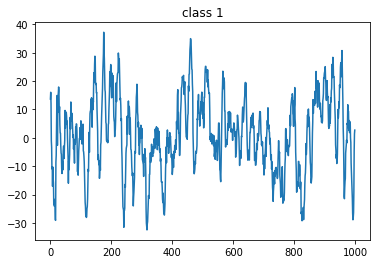

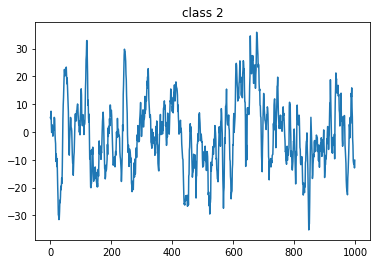

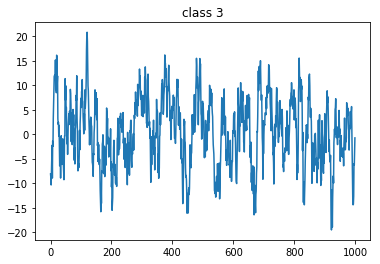

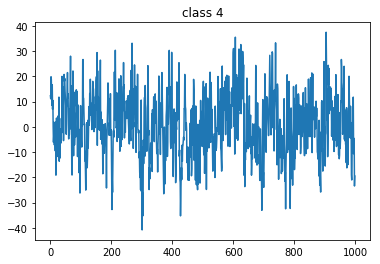

In [5]:
class1 = np.argmax( y_train == 769)
class2 = np.argmax( y_train == 770)
class3 = np.argmax( y_train == 771)
class4 = np.argmax( y_train == 772)
EEG0_class1 = X_train[class1,0,:]
EEG0_class2 = X_train[class2,0,:]
EEG0_class3 = X_train[class3,0,:]
EEG0_class4 = X_train[class4,0,:]

plt.plot(range(1000), EEG0_class1)
plt.title("class 1")
plt.show()

plt.plot(range(1000), EEG0_class2)
plt.title("class 2")
plt.show()

plt.plot(range(1000), EEG0_class3)
plt.title("class 3")
plt.show()

plt.plot(range(1000), EEG0_class4)
plt.title("class 4")
plt.show()

In [ ]:
class1_idx = np.argwhere(y_train==769).flatten()
class2_idx = np.argwhere(y_train==770).flatten()
class3_idx = np.argwhere(y_train==771).flatten()
class4_idx = np.argwhere(y_train==772).flatten()

class_idxs = [class1_idx, class2_idx, class3_idx, class4_idx]

EEG_NUM = 10 # 0-21
CLASS_NUM = 2 # 0,1,2,3

for i in np.arange(5):
    EEG_trial = X_train[class_idxs[CLASS_NUM][i],EEG_NUM,:]
    EEG_trial_fft, freqs = fft_electrode_data(EEG_trial)
    plt.bar(freqs, EEG_trial_fft)
    plt.title("Class: {}, EEG Number: {}, Individual: {}".format(CLASS_NUM, EEG_NUM, i))
    plt.show()

## Classifying data using a CNN

In [83]:
cnn = CNN(X_train, y_train_labels, X_val, y_val_labels, X_test, y_test_labels, start=100,end=600,downsample=10)
cnn.train(stride=2, optimizer='adam', epochs=7)
test_loss, test_accuracy = cnn.evaluate()

#cnn.show_model()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Train on 1904 samples, validate on 211 samples
Epoch 1/7
1904/1904 [==============================] - 4s 2ms/sample - loss: 1.4430 - acc: 0.2763 - val_loss: 1.3901 - val_acc: 0.3128
Epoch 2/7
1904/1904 [==============================] - 0s 260us/sample - loss: 1.2812 - acc: 0.3981 - val_loss: 1.4705 - val_acc: 0.3270
Epoch 3/7
1904/1904 [==============================] - 0s 259us/sample - loss: 1.1867 - acc: 0.4711 - val_loss: 1.5101 - val_acc: 0.2559
Epoch 4/7
1904/1904 [==============================] - 0s 258us/sample - loss: 1.0113 - acc: 0.5536 - val_loss: 1.8094 - val_acc: 0.3270
Epoch 5/7
1904/1904 [==============================] - 0s 261us/sample - loss: 0.9094 - acc: 0.6282 - val_loss: 1.8664 - val_acc: 0.2701
Epoch 6/7
1904/1904 [==============================] - 0s 259us/sample - loss: 0.7817 - acc: 0.6959 - val_loss: 1.8386 - val_acc: 0.3081
Epoch 7/7
443/443 [==============================] - 0s 127us/sample - loss: 2.3788 - acc: 0.2957
Test loss: 2.3788119250441784
Test 

## Classifying data using an LSTM Architecture

In [52]:
starts = [0, 100, 200, 300, 400, 500]
ends = [500, 600, 700, 800, 900, 1000]
downsamples = [5, 10]
bestrnn = None
bestacc = 0
bestparams = []
params_accuracies = []

for i in range(2):
    start = starts[i]
    end = ends[i]
    for downsample in downsamples:
        params = [start, end, downsample]
        print ("Training with params = " + str(params))
        rnn = RNN(X_train, y_train_labels, X_val, y_val_labels, 
                  X_test, y_test_labels,
                  start=start, end=end, downsample=downsample)
        rnn.train(RNN_architecture=LSTM, activation="softmax", \
                      optimizer='adam', epochs=5, batch_size=100, dropout=0.3, units=400)
        val_loss, val_accuracy = rnn.evaluate_validation()
        params_accuracies.append([params, val_accuracy])
        if (val_accuracy > bestacc):
            bestrnn = rnn
            bestacc = val_accuracy
            bestparams = params
            
print("Best val, params are: ")
print(bestacc)
print(bestparams)

test_loss, test_accuracy = bestrnn.evaluate()

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

print("All params and accuracies: ")
print(params_accuracies)


Training with params = [0, 500, 5]
Train on 1904 samples, validate on 211 samples
Epoch 1/5
1904/1904 [==============================] - 24s 13ms/step - loss: 1.5329 - acc: 0.2553 - val_loss: 1.4518 - val_acc: 0.2512
Epoch 2/5
1904/1904 [==============================] - 14s 8ms/step - loss: 1.4142 - acc: 0.3009 - val_loss: 1.4034 - val_acc: 0.2796
Epoch 3/5
1904/1904 [==============================] - 15s 8ms/step - loss: 1.3728 - acc: 0.3183 - val_loss: 1.4025 - val_acc: 0.3365
Epoch 4/5
1904/1904 [==============================] - 15s 8ms/step - loss: 1.3423 - acc: 0.3629 - val_loss: 1.4341 - val_acc: 0.2796
Epoch 5/5
1904/1904 [==============================] - 15s 8ms/step - loss: 1.3307 - acc: 0.3671 - val_loss: 1.3846 - val_acc: 0.3128
Training with params = [0, 500, 10]
Train on 1904 samples, validate on 211 samples
Epoch 1/5


KeyboardInterrupt: 

In [55]:
#best was 0, 500, 10. train with these parameters
rnn = RNN(X_train, y_train_labels, X_val, y_val_labels, 
                  X_test, y_test_labels,
                  start=0, end=500, downsample=10)
rnn.train(RNN_architecture=LSTM, activation="softmax", \
              optimizer='adam', epochs=15, batch_size=100, dropout=0.5, units=500)
val_loss, val_accuracy = rnn.evaluate_validation()

    #best val acc ~= 0.45

Train on 1904 samples, validate on 211 samples
Epoch 1/15
1904/1904 [==============================] - 26s 14ms/step - loss: 1.6013 - acc: 0.2463 - val_loss: 1.3879 - val_acc: 0.2938
Epoch 2/15
1904/1904 [==============================] - 12s 6ms/step - loss: 1.4951 - acc: 0.3046 - val_loss: 1.4562 - val_acc: 0.3175
Epoch 3/15
1904/1904 [==============================] - 11s 6ms/step - loss: 1.4673 - acc: 0.3214 - val_loss: 1.4034 - val_acc: 0.3839
Epoch 4/15
1904/1904 [==============================] - 12s 6ms/step - loss: 1.4253 - acc: 0.3382 - val_loss: 1.3058 - val_acc: 0.4076
Epoch 5/15
1904/1904 [==============================] - 11s 6ms/step - loss: 1.3866 - acc: 0.3661 - val_loss: 1.3072 - val_acc: 0.4028
Epoch 6/15
1904/1904 [==============================] - 12s 6ms/step - loss: 1.3644 - acc: 0.3734 - val_loss: 1.3137 - val_acc: 0.4171
Epoch 7/15
1904/1904 [==============================] - 11s 6ms/step - loss: 1.3027 - acc: 0.4086 - val_loss: 1.4267 - val_acc: 0.3839
Epoch 8

## Classifying Data using a GRU Architecture

In [8]:
rnn = RNN(X_train, y_train_labels, X_val, y_val_labels, X_test, y_test_labels)
rnn.train(RNN_architecture=GRU, activation="sigmoid", \
              optimizer='adam', epochs=5, batch_size=64, dropout=0.1)
test_loss, test_accuracy = rnn.evaluate()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Train on 1904 samples, validate on 211 samples
Epoch 1/5
1904/1904 [==============================] - 4s 2ms/step - loss: 1.4226 - acc: 0.2973 - val_loss: 1.3850 - val_acc: 0.2938
Epoch 2/5
1904/1904 [==============================] - 3s 1ms/step - loss: 1.1230 - acc: 0.5572 - val_loss: 1.4535 - val_acc: 0.2796
Epoch 3/5
1904/1904 [==============================] - 3s 2ms/step - loss: 0.8849 - acc: 0.6665 - val_loss: 1.4832 - val_acc: 0.3507
Epoch 4/5
1904/1904 [==============================] - 3s 1ms/step - loss: 0.6635 - acc: 0.8036 - val_loss: 1.5578 - val_acc: 0.3839
Epoch 5/5
1904/1904 [==============================] - 3s 1ms/step - loss: 0.4743 - acc: 0.8813 - val_loss: 1.5822 - val_acc: 0.3649
Test loss: 1.6185275849047418
Test accuracy: 0.336343114384141


## Autoencoder

In [116]:
normed_X_train = X_train/np.max(X_train)
normed_X_val = X_val/np.max(X_val)
normed_X_test = X_test/np.max(X_test)
autoencoder = Autoencoder(X_train, X_val, X_test)
autoencoder.train(epochs=40, encoded_dim=500)
new_data = autoencoder.predict(X_train)



Train on 1904 samples, validate on 211 samples
Epoch 1/40
1904/1904 [==============================] - 30s 16ms/sample - loss: 108.3253 - acc: 0.0056 - val_loss: 107.1181 - val_acc: 0.0106
Epoch 2/40
1904/1904 [==============================] - 24s 12ms/sample - loss: 99.0897 - acc: 0.0103 - val_loss: 101.7480 - val_acc: 0.0129
Epoch 3/40
1904/1904 [==============================] - 24s 13ms/sample - loss: 93.2242 - acc: 0.0153 - val_loss: 97.9162 - val_acc: 0.0125
Epoch 4/40
1904/1904 [==============================] - 24s 13ms/sample - loss: 88.5666 - acc: 0.0171 - val_loss: 94.5764 - val_acc: 0.0127
Epoch 5/40
1904/1904 [==============================] - 23s 12ms/sample - loss: 84.9396 - acc: 0.0238 - val_loss: 92.2143 - val_acc: 0.0222
Epoch 6/40
1904/1904 [==============================] - 24s 13ms/sample - loss: 81.9651 - acc: 0.0260 - val_loss: 90.2797 - val_acc: 0.0207
Epoch 7/40
1904/1904 [==============================] - 28s 15ms/sample - loss: 79.3873 - acc: 0.0328 - val_lo

In [117]:
abs_err = np.abs(normed_X_train - new_data)
print("Absolute Error in encoded data is roughly: " + str(np.mean(abs_err)))
print(normed_X_train[0,0,0:50])
print(new_data[0,0,0:50])


Absolute Error in encoded data is roughly: 6.08459320201086
[ 0.03665689  0.20918866  0.14125122  0.16764418  0.1627566   0.10752688
  0.10166178  0.22189638  0.15004888  0.21603128  0.228739    0.07673509
 -0.02394917 -0.1143695  -0.07624633 -0.11339198 -0.18523949 -0.04398827
 -0.06060606 -0.06207234 -0.06353861 -0.07869013  0.03616813 -0.02932551
 -0.02492669  0.01515152 -0.02346041  0.1402737   0.03128055  0.10508309
  0.14760508  0.09090909  0.04398827  0.05865103  0.05083089  0.16666667
  0.24535679  0.1769306   0.08455523  0.11827957  0.01368524  0.0058651
  0.02248289  0.0943304   0.09530792  0.00488759  0.08357771  0.12072336
  0.1026393   0.27956989]
[ 6.2504344   6.0563593   8.863367    8.058128    7.700963    7.5402336
  7.117714   10.272694    9.55111    12.188874   12.0398445   9.150469
  4.588251    4.543474    3.5055912   2.3399453   2.3499703   0.8512317
  3.3681405   2.2637339  -0.13054201  2.376885    2.0290608   3.398606
  5.0881686   6.589847    6.3338265   9.20395

## Plot of original data, and autoencoded data

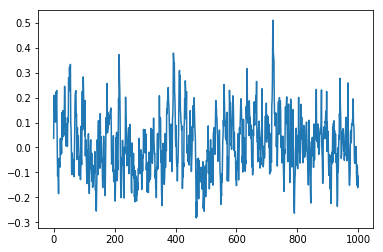

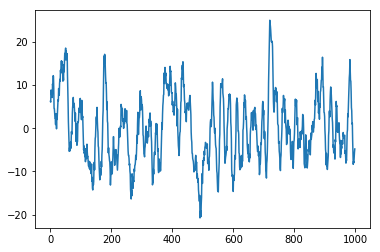

In [118]:
original = normed_X_train[0,0,:]
autoencoded = new_data[0,0,:]

plt.plot(range(len(original)), original)
plt.show()

plt.plot(range(len(autoencoded)), autoencoded)
plt.show()

## Training with autoencoder data

In [56]:
X_train_total = np.concatenate((X_train, new_data), axis=0)
y_train_total = np.concatenate((y_train_labels, y_train_labels), axis=0)

rnn = RNN(new_data, y_train_labels, X_val, y_val_labels, X_test, y_test_labels, 
         start=0, end=500, downsample=10)
rnn.train(RNN_architecture=LSTM, activation="softmax", \
              optimizer='adam', epochs=10, batch_size=100, dropout=0.3, units=500)
test_loss, test_accuracy = rnn.evaluate()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


rnn.plot()

NameError: name 'new_data' is not defined